In [1]:
import sys
sys.path.append('..')
import feature_spaces
import encoding_utils
import dvu
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
import seaborn as sns
import os
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
viz_cortex = __import__('03_viz_cortex')
from typing import List
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import datasets
%load_ext autoreload
%autoreload 2

from feature_spaces import *
from feature_spaces import em_data_dir, data_dir, results_dir
# from fit_linear_models import get_dsets
# from ridge_utils.SemanticModel import SemanticModel
dvu.set_style()

corrs = {
    k: np.load(join(results_dir, 'encoding', k, 'UTS03', 'corrs.npz'))['arr_0']
        for k in tqdm(sorted(os.listdir(join(results_dir, 'encoding'))))
        # for k in ['glove', 'eng1000', 'bert-10__ndel=4']
        if os.path.exists(join(results_dir, 'encoding', k, 'UTS03', 'corrs.npz'))
}

100%|██████████| 46/46 [00:19<00:00,  2.42it/s]


In [32]:
def get_mets(c):
    top1 = c[c >= np.percentile(c, 99)]
    top5 = c[c >= np.percentile(c, 95)]
    return {
        'mean': np.mean(c),
        'mean-top1%': np.mean(top1),
        'mean-top5%': np.mean(top5),
        'frac>0': np.mean(c > 0),
        'frac>.2': np.mean(c > 0.2),
        'mean_sem': np.std(c) / np.sqrt(c.size),
        'mean_sem-top1%': np.std(top1) / np.sqrt(top1.size),
        'mean_sem-top5%': np.std(top5) / np.sqrt(top5.size),
    }

mets = []
for k in corrs:
    c = corrs[k]
    met = get_mets(c)
    met['model'] = k
    mets.append(met)
mets = pd.DataFrame.from_dict(mets).round(3) #.set_index('model')
# m = mets[~mets.model.str.contains('mlp') & ~mets.model.str.contains('__pc') & ~mets.model.str.contains('sst')]
# m.style.set_precision(3).background_gradient(axis='index', cmap='plasma')

Print main-text table

In [34]:
index = index = {
    'bert-20__ndel=1': 'BERT',
    'bert-10__ndel=4': 'Emb-GAM (BERT)',
    # 'eng1000__ndel=4': 'Eng1000',
    # 'glove__ndel=4': 'GloVe',
}
# main = m[m.model.str.contains('-10') | m.model.str.contains('glove') | m.model.str.contains('eng1000')]
main = (
    mets
    .set_index('model')
    .loc[index.keys()]
    .rename(index=index)
    .reset_index()
    .drop(columns=['frac>0', 'frac>.2'])
    .rename(
        columns={
            'model': 'Model',
            'mean': '$\rho$',
            'mean-top1%': '\\makecell{$\rho$\\\\(top 1\%)}',
            'mean-top5%': '\\makecell{$\rho$\\\\(top 5\%)}',
            # 'frac>0': '\\makecell{Percentage voxels\\\\($\rho > 0$)}',
            # 'frac>.2': '\\makecell{Percentage voxels\\\\($\rho > 0.2$)}',
        },
    )
)
main.style.set_precision(3).background_gradient(axis='index', cmap='plasma')
print(main.to_latex(index=False, escape=False, column_format='lccccc'))


\begin{tabular}{lccccc}
\toprule
         Model &  $\rho$ &  \makecell{$\rho$\\(top 1\%)} &  \makecell{$\rho$\\(top 5\%)} &  mean_sem &  mean_sem-top1% &  mean_sem-top5% \\
\midrule
          BERT &   0.053 &                         0.524 &                         0.429 &     0.000 &           0.001 &           0.001 \\
Emb-GAM (BERT) &   0.062 &                         0.586 &                         0.489 &     0.001 &           0.001 &           0.001 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_329315/1714222086.py:26: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  main.style.set_precision(3).background_gradient(axis='index', cmap='plasma')
/tmp/ipykernel_329315/1714222086.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(main.to_latex(index=False, escape=False, column_format='lccccc'))


Print supp-text table

In [20]:
# main = m[m.model.str.contains('-10') | m.model.str.contains('glove') | m.model.str.contains('eng1000')]
index={
    'eng1000__ndel=4': 'Eng1000',
    'glove__ndel=4': 'GloVe',
    'bert-5__ndel=1': 'BERT-5',
    'bert-10__ndel=1': 'BERT-10',
    'bert-20__ndel=1': 'BERT-20',
    'bert-5__ndel=4': 'Emb-GAM (BERT)-5',
    'bert-10__ndel=4': 'Emb-GAM (BERT)-10',
    'bert-20__ndel=4': 'Emb-GAM (BERT)-20',
}
supp = (
    mets
    .set_index('model')
    .loc[index.keys()] #'eng1000__ndel=4', 'glove__ndel=4']]
    .rename(index=index)
    .reset_index()
    .drop(columns=['frac>0', 'frac>.2'])
    .rename(
        columns={
            'model': 'Model',
            'mean': '$\rho$',
            'mean-top1%': '\\makecell{$\rho$\\\\(top 1\%)}',
            'mean-top5%': '\\makecell{$\rho$\\\\(top 5\%)}',
            'frac>0': '\\makecell{Percentage voxels\\\\($\rho > 0$)}',
            'frac>.2': '\\makecell{Percentage voxels\\\\($\rho > 0.2$)}',
        },
    )
)
supp.style.set_precision(3).background_gradient(axis='index', cmap='plasma')
print(supp.to_latex(index=False, escape=False, column_format='lccccc'))


\begin{tabular}{lccccc}
\toprule
            Model &  $\rho$ &  \makecell{$\rho$\\(top 1\%)} &  \makecell{$\rho$\\(top 5\%)} \\
\midrule
          Eng1000 &   0.041 &                         0.529 &                         0.439 \\
            GloVe &   0.044 &                         0.521 &                         0.426 \\
           BERT-5 &   0.022 &                         0.386 &                         0.302 \\
          BERT-10 &   0.035 &                         0.457 &                         0.365 \\
          BERT-20 &   0.053 &                         0.524 &                         0.429 \\
 Emb-GAM (BERT)-5 &   0.061 &                         0.583 &                         0.489 \\
Emb-GAM (BERT)-10 &   0.062 &                         0.586 &                         0.489 \\
Emb-GAM (BERT)-20 &   0.056 &                         0.566 &                         0.470 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_329315/1158881445.py:30: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  supp.style.set_precision(3).background_gradient(axis='index', cmap='plasma')
/tmp/ipykernel_329315/1158881445.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(supp.to_latex(index=False, escape=False, column_format='lccccc'))


# Flatmap diff

In [5]:
viz_cortex.quickshow(corrs['bert-10__ndel=4'] - corrs['bert-20__ndel=1'], fname_save='embgam.pdf')

# Extra plots

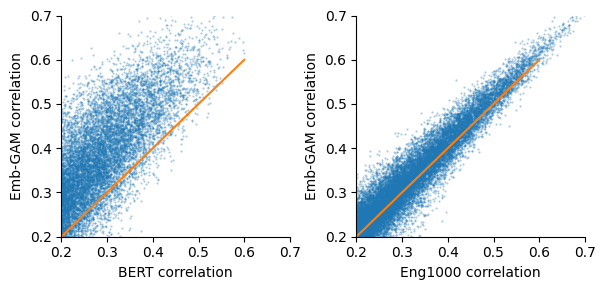

In [14]:
R, C = 1, 3
glove = 'glove__ndel=4'
bert = 'bert-10__ndel=4'
bert_def = 'bert-10__ndel=1'
bert_long = 'bert-20__ndel=4'
eng1000 = 'eng1000__ndel=4'

def set_axes():
    plt.plot([-.4, .6], [-.4, .6])
    plt.xlim([0.2, .7])
    plt.ylim([0.2, 0.7])
    plt.ylabel('Emb-GAM correlation')


plt.figure(figsize=(C * 3, R * 3))
plt.subplot(R, C, 1)
plt.plot(corrs[bert_def], corrs[bert], '.', alpha=0.4, ms=1)
plt.xlabel('BERT correlation')
set_axes()

plt.subplot(R, C, 2)
plt.plot(corrs[bert_long], corrs[bert], '.', alpha=0.4, ms=1)
plt.xlabel('Eng1000 correlation')
set_axes()

# plt.subplot(R, C, 3)
# plt.plot(corrs[bert_long], corrs[bert], '.', alpha=0.4, ms=1)
# plt.xlabel('BERT-long correlation')
# set_axes()

plt.tight_layout()
plt.show()